# Assignment 3: Convolutional neural networks for classification

The goal of this assignment is to demonstrate the Keras API for implementing and training convolutional neural network architectures. Furthermore, you get to work with the PatchCAMELYON (or PCAM) dataset that you should also use for the main project work. Essentially, this assignment demonstrated a minimal working example for the main project work.

### Preliminaries

The full working code of the example convolutional neural network can be found in the `cnn.py` file. As before, we will go over the components of the code in this Python notebook, however, you are strongly encouraged to perform all experiments using `cnn.py`. We start with importing the required libraries and defining the size of the images in the PCAM dataset.


In [1]:
import os

import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Flatten, Dense
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.models import model_from_json


# unused for now, to be used for ROC analysis
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
# the size of the images in the PCAM dataset
IMAGE_SIZE = 96

### Instantiating data generators

Compared to the MNIST dataset, the PatchCAMELYON dataset is too big to fit in the working memory of most personal computers. This is why, we need to define some functions that will read the image data batch by batch, so only a single batch of images needs to be stored in memory at one time point. We can use the handy ImageDataGenerator function from the Keras API to do this. Note that the generators are defined within a function that returns them as output arguments. This function will later be called from the main code body. 


In [3]:
def get_pcam_generators(base_dir, train_batch_size=32, val_batch_size=32):

     # dataset parameters
     TRAIN_PATH = os.path.join(base_dir, 'train+val', 'train')
     VALID_PATH = os.path.join(base_dir, 'train+val', 'valid')

     RESCALING_FACTOR = 1./255
     
     # instantiate data generators
     datagen = ImageDataGenerator(rescale=RESCALING_FACTOR)

     train_gen = datagen.flow_from_directory(TRAIN_PATH,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=train_batch_size,
                                             class_mode='binary')

     val_gen = datagen.flow_from_directory(VALID_PATH,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=val_batch_size,
                                             class_mode='binary',
                                             shuffle=False)
     
     return train_gen, val_gen

### Building a convolutional neural network classification model

The convolutional neural network model is also defined within a function. Organizing the code into functions instead of piling everything up in a single script makes the code more clear to read and understand, and helps reuse functionality that is already implemented. For example, we can use the `get_pcam_generators()` function to create data generators with different batch sizes just by calling the function with a different set of parameters. Or, we can use the `get_model()` function to generate networks with different number of feature maps (see below). 

The convolutional neural network model consists of two convolutional layers, each one followed by a max pooling layer and a fully connected layer with 64 neurons. The kernel size and number of filters of the two convolutional layers, and the size of the max pooling regions can be passed as input parameters to the function (however, note that default values are set so the function can be called without parameters). ReLU nonlinearities are used throughout the network, except for the output neuron that is activated with a sigmoid. 

In [35]:
def get_model(kernel_size=(3,3), pool_size=(4,4), first_filters=32, second_filters=64):


     # build the model
     model = Sequential()

     model.add(Conv2D(first_filters, kernel_size, activation = 'relu', padding = 'same', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
     model.add(MaxPool2D(pool_size = pool_size)) 

     model.add(Conv2D(second_filters, kernel_size, activation = 'relu', padding = 'same'))
     model.add(MaxPool2D(pool_size = pool_size))

     model.add(Flatten())
     model.add(Dense(64, activation = 'relu'))
     model.add(Dense(1, activation = 'sigmoid'))
     
    
     # compile the model
     model.compile(SGD(learning_rate=0.01, momentum=0.95), loss = 'binary_crossentropy', metrics=['accuracy'])

     return model

Now, the two functions that define the model and the data generators can be called from the main code body. Before executing the code block below, do not forget to change the path where the PatchCAMELYON dataset is located (that is, the location of the folder that contains `train+val` that you previously downloaded and unpacked).

If everything is correct, the following output will be printed on screen after executing the code block:

`Found 144000 images belonging to 2 classes.`

`Found 16000 images belonging to 2 classes.`

In [36]:
# get the model
model = get_model()

# get the data generators
train_gen, val_gen = get_pcam_generators(r'C:\Users\20212208\OneDrive - TU Eindhoven\Desktop\8P361\Project_8P')

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


If you want to know the shapes of the outputs of all layers in the network (the dimensionality of the feature maps), you can print them in the following way:

In [37]:
for layer in model.layers:
    print(layer.output_shape)

(None, 96, 96, 32)
(None, 24, 24, 32)
(None, 24, 24, 64)
(None, 6, 6, 64)
(None, 2304)
(None, 64)
(None, 1)


### Training and evaluating the model

Finally, the model can be trained using data generated by the data generators and then evaluated. This is done in a similar way to the previous assignment. Furthermore, in addition to the Tensorflow callback, an additional callback that saves the "best" version of the trained model to a file is added, and the model structure is saved to a json file. This enables loading the model and corresponding weights at a later time point (e.g. when we want to evaluate the model on a test set). 

In [6]:
# save the model and weights
model_name = 'my_first_cnn_model'
model_filepath = model_name + '.json'
weights_filepath = model_name + '_weights.hdf5'

model_json = model.to_json() # serialize model to JSON
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json) 


# define the model checkpoint and Tensorboard callbacks
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join('logs', model_name))
callbacks_list = [checkpoint, tensorboard]


# train the model
train_steps = train_gen.n//train_gen.batch_size
val_steps = val_gen.n//val_gen.batch_size

history = model.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=3,
                    callbacks=callbacks_list)

Epoch 1/3
4500/4500 [==============================] - ETA: 0s - loss: 0.4658 - accuracy: 0.7816
Epoch 1: val_loss improved from inf to 0.40663, saving model to my_first_cnn_model_weights.hdf5
4500/4500 [==============================] - 1036s 230ms/step - loss: 0.4658 - accuracy: 0.7816 - val_loss: 0.4066 - val_accuracy: 0.8183
Epoch 2/3
   1/4500 [..............................] - ETA: 8:47 - loss: 0.3356 - accuracy: 0.9375

C:\Users\20212208\AppData\Local\anaconda3\envs\8p361\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4500/4500 [==============================] - ETA: 0s - loss: 0.3808 - accuracy: 0.8315
Epoch 2: val_loss improved from 0.40663 to 0.34973, saving model to my_first_cnn_model_weights.hdf5
4500/4500 [==============================] - 370s 82ms/step - loss: 0.3808 - accuracy: 0.8315 - val_loss: 0.3497 - val_accuracy: 0.8564
Epoch 3/3
4500/4500 [==============================] - ETA: 0s - loss: 0.3360 - accuracy: 0.8555
Epoch 3: val_loss improved from 0.34973 to 0.32438, saving model to my_first_cnn_model_weights.hdf5
4500/4500 [==============================] - 254s 56ms/step - loss: 0.3360 - accuracy: 0.8555 - val_loss: 0.3244 - val_accuracy: 0.8609


## Exercise 1 
If a model has been trained, it can be loaded with the following code. This also generates an ROC curve from the validation set.

Found 16000 images belonging to 2 classes.
500/500 [==============================] - 13s 26ms/step


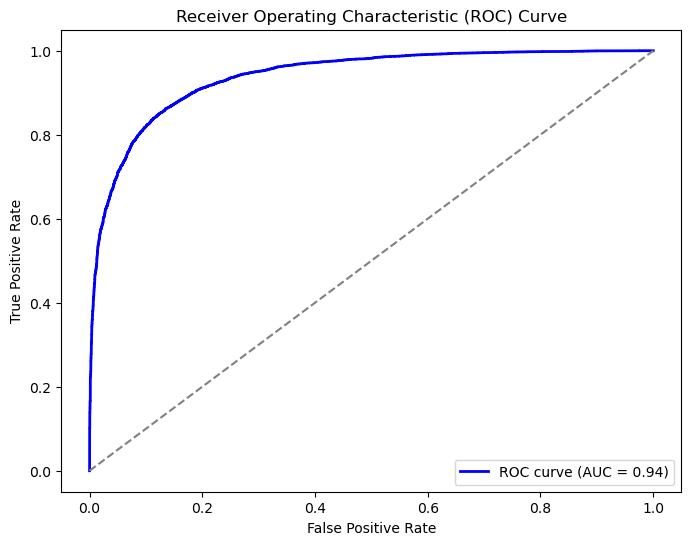

In [14]:
# Define paths
VALIDATION_DIR = r"train+val\valid"
MODEL_JSON_PATH = r"my_first_cnn_model.json"
MODEL_WEIGHTS_PATH = r"my_first_cnn_model_weights.hdf5"

# Load model architecture from JSON
with open(MODEL_JSON_PATH, "r") as json_file:
    model_json = json_file.read()

model = model_from_json(model_json)  # Recreate model from JSON structure
model.load_weights(MODEL_WEIGHTS_PATH)  # Load trained weights

# Load validation dataset
IMG_SIZE = (96, 96)  # Adjust to match original training size
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1.0/255)  # Normalize images
valid_generator = datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False  # Keep order for ROC computation
)

# Get ground truth labels
y_true = valid_generator.classes

# Generate predictions
y_pred_probs = model.predict(valid_generator)  # Probabilities
y_pred_labels = (y_pred_probs > 0.5).astype(int)  # Convert to binary labels

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Exercise 2
A NN model that only uses convolutional layers has less weights per layer, so it is computationally easier. It also sees more small features rather than larger ones. In this case, we mostly look at small features in the images.

In [4]:
def get_model2(kernel_size=(3,3), pool_size=(4,4), first_filters=32, second_filters=64, third_filters=128):
    model = Sequential()
    
    model.add(Conv2D(first_filters, kernel_size, activation='relu', padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(MaxPool2D(pool_size=pool_size))
    
    model.add(Conv2D(second_filters, kernel_size, activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=pool_size))
    
    model.add(Conv2D(third_filters, kernel_size, activation='relu', padding='same'))  # Added third convolutional layer
    model.add(MaxPool2D(pool_size=pool_size))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Changed to single neuron with sigmoid
    
    model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.95), loss='binary_crossentropy', metrics=['accuracy'])  # Changed loss function
    
    return model

In [5]:
# get the model
model2 = get_model2()

# get the data generators
train_gen, val_gen = get_pcam_generators(r'C:\Users\20212208\OneDrive - TU Eindhoven\Desktop\8P361\Project_8P')


Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [ ]:
# save the model and weights
model_name = 'my_second_cnn_model'
model_filepath = model_name + '.json'
weights_filepath = model_name + '_weights.hdf5'

model_json = model2.to_json() # serialize model to JSON
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json) 


# define the model checkpoint and Tensorboard callbacks
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join('logs', model_name))
callbacks_list = [checkpoint, tensorboard]


# train the model
train_steps = train_gen.n//train_gen.batch_size
val_steps = val_gen.n//val_gen.batch_size

history = model2.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=3,
                    callbacks=callbacks_list)

Epoch 1/3
 371/4500 [=>............................] - ETA: 16:33 - loss: 0.6078 - accuracy: 0.6619

In [11]:
'''
TU/e BME Project Imaging 2021
Submission code for Kaggle PCAM
Author: Suzanne Wetstein
'''

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}   
import tensorflow as tf

import numpy as np

import glob
import pandas as pd
from matplotlib.pyplot import imread
from tensorflow.image import resize

from tensorflow.keras.models import model_from_json

#Change these variables to point at the locations and names of the test dataset and your models.
TEST_PATH = r'C:\Users\20212208\OneDrive - TU Eindhoven\Desktop\8P361\Project_8P\test\test' 
MODEL_FILEPATH = r'C:\Users\20212208\OneDrive - TU Eindhoven\Desktop\8P361\Project_8P\my_second_cnn_model.json' 
MODEL_WEIGHTS_FILEPATH = r'C:\Users\20212208\OneDrive - TU Eindhoven\Desktop\8P361\Project_8P\my_second_cnn_model_weights.hdf5'

# load model and model weights
json_file = open(MODEL_FILEPATH, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)


# load weights into new model
model.load_weights(MODEL_WEIGHTS_FILEPATH)


# open the test set in batches (as it is a very big dataset) and make predictions
test_files = glob.glob(os.path.join(TEST_PATH, '*.tif'))

submission = pd.DataFrame()

file_batch = 5000
max_idx = len(test_files)

for idx in range(0, max_idx, file_batch):

    print('Indexes: %i - %i'%(idx, idx+file_batch))

    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]})


    # get the image id 
    test_df['id'] = test_df.path.map(lambda x: x.split(os.sep)[-1].split('.')[0])
    test_df['image'] = test_df['path'].map(imread)
    
    
    K_test = np.stack(test_df['image'].values)
    
    # apply the same preprocessing as during draining
    K_test = K_test.astype('float')/255.0
    
    predictions = model.predict(K_test)
    print(predictions[:10])  # Print first 10 predictions to check

    
    test_df['label'] = predictions
    submission = pd.concat([submission, test_df[['id', 'label']]])


# save your submission
submission.head()
submission.to_csv('submission.csv', index = False, header = True)

Indexes: 0 - 5000
157/157 [==============================] - 3s 19ms/step
[[0.8301379 ]
 [0.9128833 ]
 [0.47863248]
 [0.7037635 ]
 [0.03886302]
 [0.16808137]
 [0.18903156]
 [0.4287305 ]
 [0.90194786]
 [0.850554  ]]
Indexes: 5000 - 10000
157/157 [==============================] - 3s 19ms/step
[[0.3044765 ]
 [0.4742706 ]
 [0.02909475]
 [0.12459732]
 [0.25265536]
 [0.99496305]
 [0.4482505 ]
 [0.42565012]
 [0.03433973]
 [0.09696168]]
Indexes: 10000 - 15000
157/157 [==============================] - 3s 18ms/step
[[0.11692078]
 [0.7492732 ]
 [0.0838044 ]
 [0.96604437]
 [0.72775996]
 [0.03576782]
 [0.23170806]
 [0.6837012 ]
 [0.73469543]
 [0.7660514 ]]
Indexes: 15000 - 20000
157/157 [==============================] - 3s 19ms/step
[[0.07964484]
 [0.97525066]
 [0.04091775]
 [0.03354031]
 [0.94978684]
 [0.09173416]
 [0.7783908 ]
 [0.9487692 ]
 [0.01213949]
 [0.998688  ]]
Indexes: 20000 - 25000
157/157 [==============================] - 3s 19ms/step
[[0.5394446 ]
 [0.7626631 ]
 [0.30907917]
 [0.1

In case you are wondering why (for the first epochs in particular) the validation accuracy is much higher than the training accuracy and the validation loss is lower than the training loss, you can find your answer in the [Keras FAQ](https://keras.io/getting_started/faq/).

### Before you start with the exercises...

Make sure that you understand all new code components introduced in the example. Remember: you can always lookup the documentation of the used functions to get a better understanding about how they work.

[This blog post](http://karpathy.github.io/2019/04/25/recipe/) by Andrej Kaprapthy with tips and tricks for training neural networks is highly recommended reading material.

## Exercise 1

The PatchCAMELYON challenge on Kaggle uses the area under the ROC curve as an evaluation measure. Describe the concept of ROC curve analysis and the area under the ROC curve (AUC) as an evaluation measure. Then, using methods from the sklearn Python toolbox (the required functions are alerady imported), perform ROC curve analysis and computation of the AUC for your model. 

Note that you will have to do this analysis on the validation set (since you do not have access to the ground truth for the test set). 

## Exercise 2

It is possible to construct a neural network model that is equivalent to the model above, however, only using convolutional layers (i.e. without using any fully connected or "dense" layers). Construct and train such a model. 

What would be the advantage of only using convolutional layers?


## Exercise 3

Use the `kaggle_submission.py` file to prepare and submit results for evaluation to Kaggle. What is the result of the evaluation on the test set? How does it compare to the evaluation that you performed on the validation set?

## Submission checklist

* Exercise 1: Answer to the questions and code
* Exercise 2: Answer to the questions and code
* Exercise 3: Answer to the questions and code